In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Data Preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

class WillpowerAttention(nn.Module):
    def __init__(self, goal_vector, distraction_penalty):
        super(WillpowerAttention, self).__init__()
        self.goal_vector = goal_vector
        self.distraction_penalty = distraction_penalty

    def forward(self, input_vectors):
        # Calculate cosine similarity between input vectors and goal vector
        similarity = torch.cosine_similarity(input_vectors, self.goal_vector.unsqueeze(0))

        # Increase attention weight for more goal-aligned inputs
        attention_weights = similarity + 1
        # Penalize attention weights for distracting inputs
        attention_weights = attention_weights - self.distraction_penalty
        # Normalize attention weights
        if attention_weights.dim() == 1:
          attention_weights.unsqueeze(0)
        attention_weights = torch.softmax(attention_weights, dim=1)
        # Remove batch dimension from attention weights
        # attention_weights = attention_weights.squeeze(0).squeeze(0)
        return attention_weights

# Create a WillpowerAttention module
goal_vector = torch.randn(10)
distraction_penalty = 0.1
willpower_attention = WillpowerAttention(goal_vector, distraction_penalty)

# Pass some input vectors through the module
input_vectors = torch.cat([torch.randn(10) for _ in range(3)])
input_vectors = input_vectors.unsqueeze(1).repeat(20, 1, 1)
attention_weights = willpower_attention(input_vectors)

# Print the attention weights
print(attention_weights)


tensor([[0.0999, 0.0997, 0.1002, 0.1000, 0.0994, 0.1000, 0.1002, 0.0998, 0.1001,
         0.1007],
        [0.0999, 0.0997, 0.1002, 0.1000, 0.0994, 0.1000, 0.1002, 0.0998, 0.1001,
         0.1007],
        [0.0999, 0.0997, 0.1002, 0.1000, 0.0994, 0.1000, 0.1002, 0.0998, 0.1001,
         0.1007],
        [0.0999, 0.0997, 0.1002, 0.1000, 0.0994, 0.1000, 0.1002, 0.0998, 0.1001,
         0.1007],
        [0.0999, 0.0997, 0.1002, 0.1000, 0.0994, 0.1000, 0.1002, 0.0998, 0.1001,
         0.1007],
        [0.0999, 0.0997, 0.1002, 0.1000, 0.0994, 0.1000, 0.1002, 0.0998, 0.1001,
         0.1007],
        [0.0999, 0.0997, 0.1002, 0.1000, 0.0994, 0.1000, 0.1002, 0.0998, 0.1001,
         0.1007],
        [0.0999, 0.0997, 0.1002, 0.1000, 0.0994, 0.1000, 0.1002, 0.0998, 0.1001,
         0.1007],
        [0.0999, 0.0997, 0.1002, 0.1000, 0.0994, 0.1000, 0.1002, 0.0998, 0.1001,
         0.1007],
        [0.0999, 0.0997, 0.1002, 0.1000, 0.0994, 0.1000, 0.1002, 0.0998, 0.1001,
         0.1007],
        [0

In [6]:

import math

class InterestBasedAttention(nn.Module):
    def __init__(self, d_model, n_heads, interest_vectors, willpower_factor, dropout=0.2):
        super(InterestBasedAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.dropout = dropout
        self.interest_vectors = interest_vectors
        self.willpower_factor = willpower_factor

        self.query_transform = nn.Linear(d_model, d_model)
        self.key_transform = nn.Linear(d_model, d_model)
        self.value_transform = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)
        # self.dropout1 = nn.Dropout(dropout)
        # self.dropout2 = nn.Dropout(dropout)

        self.head_dim = d_model // n_heads

    def forward(self, willpower_output):
        # Transform willpower_output into query, key, value vectors
        query = self.query_transform(willpower_output)
        key = self.key_transform(willpower_output)
        value = self.value_transform(willpower_output)

        # Split query, key, value vectors into multiple heads
        query = query.view(query.shape[0], self.n_heads, self.head_dim)
        key = key.view(key.shape[0], self.n_heads, self.head_dim)
        value = value.view(value.shape[0], self.n_heads, self.head_dim)

        # Compute dot product attention weights for each head
        dot_product_attention = torch.bmm(query, key.transpose(1, 2)) / math.sqrt(self.head_dim)
        scaled_dot_product_attention = torch.softmax(dot_product_attention, dim=2)

        # Compute interest attention weights for each head
        interest_attention = torch.matmul(query, self.interest_vectors.transpose(-1, -2))
        scaled_interest_attention = nn.functional.softmax(interest_attention, dim=-1)
        # interest_attention = interest_attention.unsqueeze(1).expand(-1, query.shape[1], -1)

        # Combine dot product attention and interest attention
        combined_attention = (1 - self.willpower_factor) * scaled_dot_product_attention + self.willpower_factor * scaled_interest_attention

        # Compute weighted sum of value vectors for each head
        head_outputs = torch.bmm(combined_attention, value)

        # Concatenate outputs from all heads and project back into original dimensionality
        output = head_outputs.view(head_outputs.shape[0], self.d_model)
        output = self.fc(output)
        # output = self.dropout2(output)

        return output


class WillpowerInterestAttention(nn.Module):
    def __init__(self, goal_vector, distraction_penalty, interest_vectors, willpower_factor, d_model, n_heads):
        super(WillpowerInterestAttention, self).__init__()
        # Initialize WillpowerAttention and InterestBasedAttention components
        self.willpower_attention = WillpowerAttention(goal_vector, distraction_penalty)
        self.interest_based_attention = InterestBasedAttention(d_model, n_heads, interest_vectors, willpower_factor)

        # MLP layers for transforming willpower output into query, key, and value vectors
        self.query_transform = nn.Linear(d_model, d_model)
        self.key_transform = nn.Linear(d_model, d_model)
        self.value_transform = nn.Linear(d_model, d_model)

    def forward(self, input_vectors):
        # Apply WillpowerAttention to input vectors
        willpower_output = self.willpower_attention(input_vectors)

        # Apply InterestBasedAttention
        output = self.interest_based_attention(willpower_output )
        return output


class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, goal_vector, distraction_penalty, interest_vectors, willpower_factor):
        super(TransformerEncoderLayer, self).__init__()

        self.willpower_interest_attention = WillpowerInterestAttention(
            goal_vector, distraction_penalty, interest_vectors, willpower_factor, d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, src):
        # WillpowerInterestAttention with residual connection
        src2 = self.willpower_interest_attention(src)
        src = src + self.norm1(src2.unsqueeze(1))

        # Feed-forward network with residual connection
        src2 = self.ffn(src)
        src = src + self.norm2(src2)
        return src

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, n_heads, goal_vector, distraction_penalty, interest_vectors, willpower_factor):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, goal_vector, distraction_penalty, interest_vectors, willpower_factor)
            for _ in range(num_layers)
        ])

    def forward(self, src):
        for layer in self.layers:
            src = layer(src)
        return src

# Example Usage
num_layers = 6
d_model = 512
n_heads = 8
head_dim = d_model // n_heads
goal_vector = torch.randn(d_model)  # Example goal vector
distraction_penalty = 0.5  # Example distraction penalty
# interest_vectors = torch.randn(n_heads, d_model)  # Example interest vectors
interest_vectors = nn.Parameter(torch.randn(n_heads, head_dim))
willpower_factor = 0.8  # Example willpower factor

encoder = TransformerEncoder(num_layers, d_model, n_heads, goal_vector, distraction_penalty, interest_vectors, willpower_factor)

input_vectors = torch.randn(10, d_model)  # Example batch of input vectors
input_vectors = input_vectors.unsqueeze(0)  # Add batch dimension
output = encoder(input_vectors)
print(output)


tensor([[[ 0.1112, -1.8311,  3.3519,  ...,  7.5776, -0.9073,  2.7162],
         [ 2.0272, -2.6744,  2.9427,  ...,  4.4454, -0.1193,  5.2979],
         [-0.3926, -2.6991,  1.0897,  ...,  5.5073,  2.4096,  6.8367],
         ...,
         [-0.6906, -3.3919,  4.8786,  ...,  4.9603,  2.9677,  3.3466],
         [ 0.3224, -0.5488,  2.5381,  ...,  7.8540,  4.3504,  3.2215],
         [ 0.9810, -3.9276,  3.4474,  ...,  5.8588,  1.5015,  2.0370]]],
       grad_fn=<AddBackward0>)


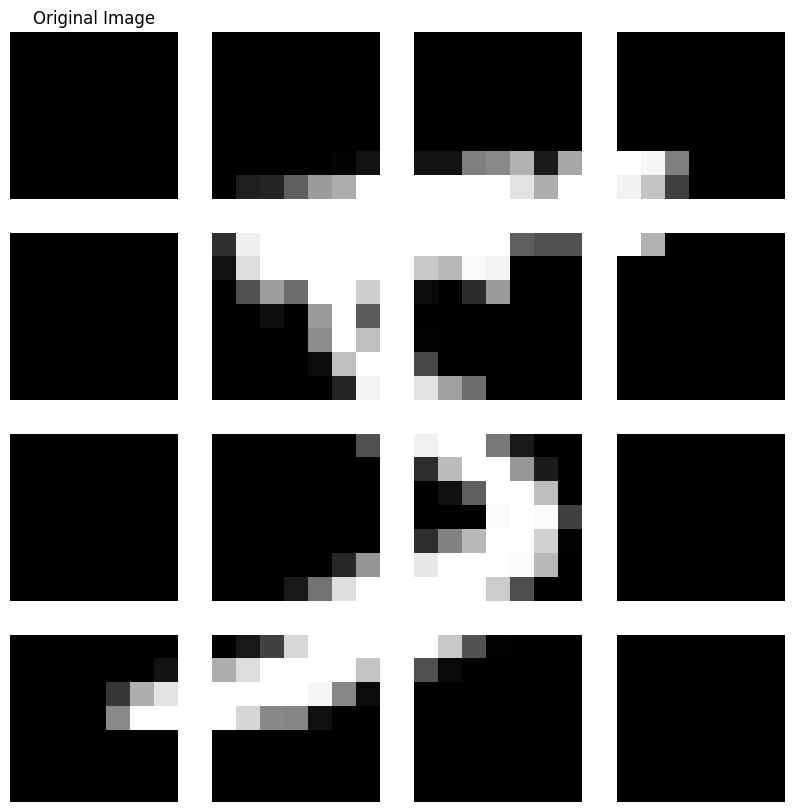

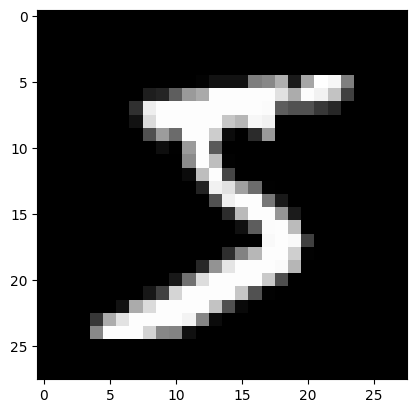

In [7]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

# Get the first image from the dataset
img = train_dataset[0][0].unsqueeze(0)  # Shape: (1, 1, 28, 28)

# Function to extract 4x4 patches from the image
def extract_patches(img, patch_size=7):
    batch_size, channels, height, width = img.shape
    assert height == 28 and width == 28, "Input image must be of size 28x28."
    assert height % patch_size == 0 and width % patch_size == 0, "Patch size must be divisible by the image dimensions."
    num_patches_height = height // patch_size
    num_patches_width = width // patch_size
    patches = []
    for i in range(batch_size):
        img_i = img[i]
        patches_i = []
        for j in range(num_patches_height):
            for k in range(num_patches_width):
                patch = img_i[:, j*patch_size:(j+1)*patch_size, k*patch_size:(k+1)*patch_size]
                patches_i.append(patch)
        patches_i = torch.stack(patches_i, dim=0)
        patches.append(patches_i)
    patches = torch.stack(patches, dim=0)
    return patches

patch_size = 28//4
# Extract patches from the image
patches_batch = extract_patches(img, patch_size=patch_size)
patches = patches_batch[0]
# Plot the original image and its patches
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs[0][0].imshow(img.squeeze(0).squeeze(0), cmap='gray')
axs[0][0].set_title('Original Image')

for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        if idx < patches.shape[0]:
            axs[i][j].imshow(patches[idx, :, :].squeeze(0), cmap='gray')
            axs[i][j].axis('off')
plt.show()

plt.imshow(img.squeeze(0).squeeze(0), cmap='gray')

In [8]:
import torchvision.models as models

# Load pre-trained ResNet-18 model
resnet_model = models.resnet18(pretrained=True)

# Replace the last fully-connected layer with a new one to obtain embeddings of size 512
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 512)

# Set the model to evaluation mode
resnet_model.eval()

def get_embeddings(resnet_model, patches):

    # Pass the patches through the model to obtain embeddings
    with torch.no_grad():
        embeddings = resnet_model(patches)

    return embeddings

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
class LogiterModel(nn.Module):
    def __init__(self, d_model, num_classes):
        super(LogiterModel, self).__init__()
        # Your transformer's architecture components
        # Assuming input_dim = 784 for MNIST (28x28 images flattened)
        # d_model is the dimensionality of the model
        # n_heads is the number of heads in multi-head attention
        # num_encoder_layers is the number of encoder layers in the transformer

        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, output):

      # Assuming src is of shape [batch_size, seq_length, d_model]
      # Take the mean of the sequence dimension as a simple form of pooling
      pooled_output = output.mean(dim=1)

      # Pass through the classification head
      logits = self.fc(pooled_output)
      return logits

In [1]:

def extract_and_embed(idx, resnet_model, self):
    data, target = self.dataset[idx]
    if type(data) != torch.Tensor:
      print(data, target)
      print("abort")
    if type(data) == int:
      print(data, target)

    self.idx_array[idx] = 1
    if idx > self.max_idx:
      percent = sum(self.idx_array)/len(self.idx_array)
      print(f"idx : {idx} ")
      print(f"percentage: {percent}")

    # data, target = data.to(self.device), target.to(self.device)
    patches = self.extract_patches(data)

    if patches.dim() == 4:
      # [16, 1, 7, 7]
      if patches.shape[1] == 1:
        patches = patches.repeat(1, 3, 1, 1)
      with torch.no_grad():
        embeddings = resnet_model(patches)

    elif patches.dim() == 5:
      # [1, 16, 1, 7, 7]
      if patches.shape[2] == 1:
        patches = patches.repeat(1, 1, 3, 1, 1)
      with torch.no_grad():
        batch_embed = []
        for pidx in tqdm(range(patches.shape[0])):
          embeddings = resnet_model(patches[pidx])
          batch_embed.append(embeddings)
        embeddings = torch.stack(batch_embed, dim=0)

    # embeddings = embeddings.cpu().numpy().flatten()
    return idx, embeddings

In [11]:
import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from multiprocessing import Pool
import functools
import collections
from tqdm import tqdm

class PatchedEmbeddingsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, patch_size, device, num_workers=20):
        self.dataset = dataset
        self.patch_size = patch_size
        self.device = device
        self.max_idx = 0
        self.idx_array = [0 for i in range(len(dataset)+10)]
        self.embeddings = self.precompute_embeddings(num_workers)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        target = self.dataset[idx][1]
        target = target.to(self.device)
        embeddings = self.embeddings[idx]
        return embeddings, target

    def precompute_embeddings(self, num_workers):
        # Load pre-trained ResNet-18 model
        self.model = models.resnet18(pretrained=True)

        # Replace the last fully-connected layer with a new one to obtain embeddings of size 512
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 512)

        # Set the model to evaluation mode
        self.model.eval()

        print("total samples: ", len(self.dataset))
        self.max_idx = 0
        # # Use multiprocessing to speed up precomputation
        with Pool(num_workers) as p:
          results = p.starmap(extract_and_embed, [(idx, self.model, self) for idx in range(len(self.dataset))])

        # Concatenate embeddings for all images
        embedding_dict = collections.defaultdict(torch.Tensor)
        embedding_dict.update({r[0]:r[1] for r in results})
        return embedding_dict

    def extract_patches(self, img):
        if type(img) == torch.Tensor and img.dim() == 3:
          batch_size = 1
          channels, height, width = img.shape
          img = img.unsqueeze(0)
        elif type(img) != torch.Tensor:
          print("Wrong input check again")
        else:
          batch_size, channels, height, width = img.shape
        assert height == 28 and width == 28, "Input image must be of size 28x28."
        assert height % self.patch_size == 0 and width % self.patch_size == 0, "Patch size must be divisible by the image dimensions."
        num_patches_height = height // self.patch_size
        num_patches_width = width // self.patch_size
        patches = []
        for i in range(batch_size):
            img_i = img[i]
            patches_i = []
            for j in range(num_patches_height):
                for k in range(num_patches_width):
                    patch = img_i[:, j*self.patch_size:(j+1)*self.patch_size, k*self.patch_size:(k+1)*self.patch_size]
                    patches_i.append(patch)
            patches_i = torch.stack(patches_i, dim=0)
            patches.append(patches_i)
        patches = torch.stack(patches, dim=0)
        return patches

    def save_embeddings(self, filename):
        torch.save(self.embeddings, filename)

    @staticmethod
    def load_embeddings(filename, device):
        embeddings = torch.load(filename, map_location=device)
        return embeddings

In [ ]:
patch_size = 28//4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset_patched = PatchedEmbeddingsDataset(train_dataset, device=device, patch_size=patch_size)
train_dataset_patched.save_embeddings("embeddings")

total samples:  60000
idx : 1500 
percentage: 1.6663889351774705e-05


100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


idx : 1501 
percentage: 3.332777870354941e-05


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 750 
percentage: 1.6663889351774705e-05

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



idx : 5250 idx : 7500 idx : 1502 


  0%|          | 0/1 [00:00<?, ?it/s]


idx : 3750 idx : 4500 idx : 2250 percentage: 1.6663889351774705e-05
percentage: 1.6663889351774705e-05



idx : 13500 percentage: 4.999166805532411e-05

100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


percentage: 1.6663889351774705e-05

100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

percentage: 1.6663889351774705e-05

percentage: 1.6663889351774705e-05



  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 1.6663889351774705e-05

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 8250 

  0%|          | 0/1 [00:00<?, ?it/s]




idx : 6750 
percentage: 1.6663889351774705e-05
idx : 3000 idx : 10500 
percentage: 1.6663889351774705e-05

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 1 

  0%|          | 0/1 [00:00<?, ?it/s]




percentage: 1.6663889351774705e-05

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 12000 


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 1.6663889351774705e-05


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 3.332777870354941e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 1.6663889351774705e-05idx : 6000 idx : 14250 

idx : 11250 idx : 9750 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


idx : 12750 

  0%|          | 0/1 [00:00<?, ?it/s]



idx : 9000 percentage: 1.6663889351774705e-05percentage: 1.6663889351774705e-05
percentage: 1.6663889351774705e-05percentage: 1.6663889351774705e-05


percentage: 1.6663889351774705e-05

percentage: 1.6663889351774705e-05

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

idx : 1503 

idx : 13501 

percentage: 3.332777870354941e-05
percentage: 6.665555740709882e-05

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


idx : 2 

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

percentage: 4.999166805532411e-05

100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

idx : 10501 

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


idx : 5251 


idx : 4501 
percentage: 3.332777870354941e-05
idx : 12001 percentage: 3.332777870354941e-05
percentage: 3.332777870354941e-05

100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 3.332777870354941e-05

  0%|          | 0/1 [00:00<?, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 751 


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

percentage: 3.332777870354941e-05

100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

idx : 8251 

100%|██████████| 1/1 [00:01<00:00,  1.58s/it]



100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

percentage: 3.332777870354941e-05idx : 7501 idx : 6751 

100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 3.332777870354941e-05idx : 2251 

100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

percentage: 3.332777870354941e-05

100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

idx : 3751 

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 3.332777870354941e-05

100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

idx : 3001 percentage: 3.332777870354941e-05




  0%|          | 0/1 [00:00<?, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 13502 percentage: 3.332777870354941e-05idx : 11251 

percentage: 4.999166805532411e-05


  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 3.332777870354941e-05

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


idx : 6001 

100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

idx : 9751 

idx : 1504 



idx : 9001 


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

percentage: 3.332777870354941e-05idx : 14251 

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

idx : 3 

percentage: 3.332777870354941e-05percentage: 8.331944675887353e-05




100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


percentage: 3.332777870354941e-05



  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 3.332777870354941e-05percentage: 6.665555740709882e-05

idx : 12751 

  0%|          | 0/1 [00:00<?, ?it/s]





idx : 10502 

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

percentage: 3.332777870354941e-05


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


percentage: 4.999166805532411e-05


  0%|          | 0/1 [00:00<?, ?it/s]


idx : 4502 

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

idx : 12002 

percentage: 4.999166805532411e-05percentage: 4.999166805532411e-05


idx : 5252 


  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 4.999166805532411e-05


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

idx : 752 

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

idx : 6752 percentage: 4.999166805532411e-05

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]



idx : 7502 

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

percentage: 4.999166805532411e-05idx : 8252 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

percentage: 4.999166805532411e-05

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]



percentage: 4.999166805532411e-05idx : 3752 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 3002 
idx : 2252 

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

percentage: 4.999166805532411e-05




idx : 13503 percentage: 4.999166805532411e-05

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 4.999166805532411e-05idx : 11252 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 6.665555740709882e-05

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

percentage: 4.999166805532411e-05

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


idx : 6002 

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

idx : 1505 idx : 9752 
idx : 4 


percentage: 4.999166805532411e-05
idx : 12752 idx : 9002 percentage: 9.998333611064822e-05

percentage: 8.331944675887353e-05


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

idx : 14252 


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 4.999166805532411e-05
percentage: 4.999166805532411e-05



100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

percentage: 4.999166805532411e-05

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

percentage: 4.999166805532411e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 10503 

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 4503 

percentage: 6.665555740709882e-05

idx : 12003 percentage: 6.665555740709882e-05

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 6.665555740709882e-05idx : 5253 


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

percentage: 6.665555740709882e-05


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

idx : 753 

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]



idx : 6753 

percentage: 6.665555740709882e-05

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

idx : 7503 



percentage: 6.665555740709882e-05

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


idx : 8253 

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


percentage: 6.665555740709882e-05

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 6.665555740709882e-05

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

idx : 3753 idx : 2253 


  0%|          | 0/1 [00:00<?, ?it/s]


idx : 3003 


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


idx : 11253 

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 6.665555740709882e-05


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]



percentage: 6.665555740709882e-05percentage: 6.665555740709882e-05



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

percentage: 6.665555740709882e-05idx : 13504 


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

idx : 6003 percentage: 8.331944675887353e-05

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

percentage: 6.665555740709882e-05idx : 1506 idx : 12753 

100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

percentage: 6.665555740709882e-05idx : 5 percentage: 0.00011664722546242292idx : 9753 

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

idx : 9003 



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


percentage: 6.665555740709882e-05

percentage: 9.998333611064822e-05

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]



percentage: 6.665555740709882e-05idx : 14253 idx : 10504 

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 4504 percentage: 6.665555740709882e-05percentage: 8.331944675887353e-05

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

percentage: 8.331944675887353e-05

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 12004 

  0%|          | 0/1 [00:00<?, ?it/s]



idx : 5254 idx : 754 percentage: 8.331944675887353e-05


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


percentage: 8.331944675887353e-05


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

percentage: 8.331944675887353e-05



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 6754 

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

percentage: 8.331944675887353e-05

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

idx : 7504 idx : 8254 


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 2254 percentage: 8.331944675887353e-05percentage: 8.331944675887353e-05

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

percentage: 8.331944675887353e-05

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

idx : 3754 


idx : 3004 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

idx : 11254 
percentage: 8.331944675887353e-05


percentage: 8.331944675887353e-05

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


idx : 13505 

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

percentage: 8.331944675887353e-05

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 6004 


  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 9.998333611064822e-05


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


idx : 12754 

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

percentage: 8.331944675887353e-05


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

idx : 1507 


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

percentage: 8.331944675887353e-05


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 6 

percentage: 0.00013331111481419764


idx : 9004 
idx : 9754 

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00011664722546242292
idx : 14254 

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

percentage: 8.331944675887353e-05percentage: 8.331944675887353e-05


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 10505 

percentage: 8.331944675887353e-05


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 9.998333611064822e-05


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

idx : 4505 


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


idx : 755 percentage: 9.998333611064822e-05



idx : 12005 percentage: 9.998333611064822e-05

  0%|          | 0/1 [00:00<?, ?it/s]


idx : 5255 
percentage: 9.998333611064822e-05

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

percentage: 9.998333611064822e-05

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

idx : 2255 


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

idx : 6755 

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

percentage: 9.998333611064822e-05idx : 7505 percentage: 9.998333611064822e-05




idx : 8255 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 3755 

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 9.998333611064822e-05

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

percentage: 9.998333611064822e-05


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]



percentage: 9.998333611064822e-05

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 11255 idx : 3005 


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

idx : 13506 

100%|██████████| 1/1 [00:01<00:00,  1.05it/s]

percentage: 9.998333611064822e-05percentage: 9.998333611064822e-05


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

idx : 6005 

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

percentage: 0.00011664722546242292

100%|██████████| 1/1 [00:01<00:00,  1.00it/s]

idx : 12755 

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 7 

percentage: 9.998333611064822e-05idx : 1508 percentage: 9.998333611064822e-05
idx : 9755 

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


idx : 9005 
percentage: 0.00013331111481419764



  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 9.998333611064822e-05percentage: 0.00014997500416597234

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


percentage: 9.998333611064822e-05


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 14255 

100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

percentage: 9.998333611064822e-05idx : 10506 

100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 12006 percentage: 0.00011664722546242292

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]



idx : 4506 


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

idx : 756 

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


percentage: 0.00011664722546242292


percentage: 0.00011664722546242292


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

percentage: 0.00011664722546242292

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

idx : 6756 



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


percentage: 0.00011664722546242292

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 5256 

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

idx : 7506 

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

100%|██████████| 1/1 [00:01<00:00,  1.26s/it]



percentage: 0.00011664722546242292

  0%|          | 0/1 [00:00<?, ?it/s]



percentage: 0.00011664722546242292idx : 8256 
idx : 3756 idx : 2256 



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.00011664722546242292

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

percentage: 0.00011664722546242292percentage: 0.00011664722546242292



100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


idx : 3006 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

percentage: 0.00011664722546242292


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

idx : 11256 

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

idx : 13507 


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

percentage: 0.00011664722546242292

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


idx : 8 

percentage: 0.00013331111481419764

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


idx : 6006 

  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


percentage: 0.00014997500416597234idx : 12756 percentage: 0.00011664722546242292



  0%|          | 0/1 [00:00<?, ?it/s]

idx : 1509 

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]



idx : 9756 idx : 9006 


  0%|          | 0/1 [00:00<?, ?it/s]



percentage: 0.00011664722546242292


percentage: 0.00011664722546242292
percentage: 0.00011664722546242292percentage: 0.00016663889351774705

  0%|          | 0/1 [00:00<?, ?it/s]


idx : 14256 


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

percentage: 0.00011664722546242292

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]



idx : 10507 


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 12007 


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

percentage: 0.00013331111481419764

percentage: 0.00013331111481419764

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

idx : 757 
idx : 4507 

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

percentage: 0.00013331111481419764percentage: 0.00013331111481419764idx : 6757 


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

idx : 5257 

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00013331111481419764


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


percentage: 0.00013331111481419764
idx : 8257 

100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


idx : 7507 

  0%|          | 0/1 [00:00<?, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 2257 

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

percentage: 0.00013331111481419764idx : 3757 percentage: 0.00013331111481419764percentage: 0.00013331111481419764


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

idx : 13508 

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00013331111481419764

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


idx : 3007 idx : 6007 

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00014997500416597234idx : 11257 

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]



idx : 9 

percentage: 0.00013331111481419764

percentage: 0.00013331111481419764
percentage: 0.00013331111481419764


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 1510 percentage: 0.00016663889351774705


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00018330278286952175

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 9007 

idx : 9757 

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

percentage: 0.00013331111481419764

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

idx : 12757 percentage: 0.00013331111481419764

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


percentage: 0.00013331111481419764idx : 14257 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 12008 
idx : 10508 

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]



percentage: 0.00013331111481419764

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.00014997500416597234


percentage: 0.00014997500416597234


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

idx : 4508 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


percentage: 0.00014997500416597234

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

idx : 758 


  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


percentage: 0.00014997500416597234

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

idx : 6758 

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

idx : 5258 



100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00014997500416597234idx : 2258 idx : 7508 

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


percentage: 0.00014997500416597234




100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

idx : 3758 
percentage: 0.00014997500416597234idx : 8258 

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

percentage: 0.00014997500416597234

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

idx : 11258 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 13509 percentage: 0.00014997500416597234

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


percentage: 0.00014997500416597234idx : 3008 




  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00014997500416597234


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 6008 percentage: 0.00016663889351774705

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00014997500416597234


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

idx : 1511 


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 10 

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


percentage: 0.00014997500416597234


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

percentage: 0.00018330278286952175

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


percentage: 0.00019996667222129644

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 9008 



  0%|          | 0/1 [00:00<?, ?it/s]

idx : 12758 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 9758 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

percentage: 0.00014997500416597234



percentage: 0.00014997500416597234percentage: 0.00014997500416597234

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 10509 
idx : 14258 

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.00016663889351774705

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

percentage: 0.00014997500416597234

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

idx : 12009 


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


percentage: 0.00016663889351774705

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

idx : 4509 


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

percentage: 0.00016663889351774705idx : 5259 


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 759 percentage: 0.00016663889351774705

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

percentage: 0.00016663889351774705

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


idx : 6759 idx : 7509 


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


idx : 8259 percentage: 0.00016663889351774705idx : 2259 percentage: 0.00016663889351774705

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


idx : 11259 

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

percentage: 0.00016663889351774705percentage: 0.00016663889351774705

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

idx : 3759 percentage: 0.00016663889351774705

idx : 3009 



  0%|          | 0/1 [00:00<?, ?it/s]


idx : 11 

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00016663889351774705idx : 13510 percentage: 0.00016663889351774705

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]



idx : 1512 

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

percentage: 0.00018330278286952175

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 12759 percentage: 0.00021663056157307116idx : 9009 percentage: 0.00019996667222129644


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

idx : 6009 




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


percentage: 0.00016663889351774705


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00016663889351774705

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


percentage: 0.00016663889351774705idx : 9759 




100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

idx : 14259 


  0%|          | 0/1 [00:00<?, ?it/s]



percentage: 0.00016663889351774705

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

idx : 10510 percentage: 0.00016663889351774705

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 12010 



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


percentage: 0.00018330278286952175

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.00018330278286952175
idx : 4510 


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

percentage: 0.00018330278286952175

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

idx : 5260 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

percentage: 0.00018330278286952175

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

idx : 6760 idx : 760 

  0%|          | 0/1 [00:00<?, ?it/s]






idx : 2260 idx : 8260 idx : 7510 percentage: 0.00018330278286952175percentage: 0.00018330278286952175

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

percentage: 0.00018330278286952175

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00018330278286952175percentage: 0.00018330278286952175

  0%|          | 0/1 [00:00<?, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 11260 

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

idx : 3760 

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


percentage: 0.00018330278286952175

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

idx : 13511 

percentage: 0.00018330278286952175idx : 1513 


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 3010 

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

percentage: 0.00019996667222129644

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]



idx : 12 

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.00023329445092484585

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

idx : 12760 percentage: 0.00018330278286952175


idx : 9010 percentage: 0.00021663056157307116

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]



idx : 6010 

percentage: 0.00018330278286952175


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


idx : 9760 


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

percentage: 0.00018330278286952175

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

percentage: 0.00018330278286952175

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 14260 percentage: 0.00018330278286952175

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]



idx : 10511 

percentage: 0.00018330278286952175

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

idx : 12011 
percentage: 0.00019996667222129644


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00019996667222129644

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

idx : 4511 


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

idx : 5261 

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

percentage: 0.00019996667222129644

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

percentage: 0.00019996667222129644

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]



idx : 7511 

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

idx : 761 



  0%|          | 0/1 [00:00<?, ?it/s]



percentage: 0.00019996667222129644idx : 6761 

100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

percentage: 0.00019996667222129644
idx : 8261 
idx : 2261 

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


percentage: 0.00019996667222129644


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

percentage: 0.00019996667222129644

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00019996667222129644


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 3761 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 13512 

idx : 11261 

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


percentage: 0.00019996667222129644

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

percentage: 0.00021663056157307116percentage: 0.00019996667222129644


  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

idx : 1514 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 9011 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 3011 




percentage: 0.00024995834027662057idx : 6011 percentage: 0.00019996667222129644
percentage: 0.00019996667222129644

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

percentage: 0.00019996667222129644

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

idx : 12761 

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

idx : 9761 
idx : 13 


percentage: 0.00019996667222129644idx : 14261 


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

percentage: 0.00019996667222129644

percentage: 0.00023329445092484585


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

percentage: 0.00019996667222129644

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 10512 


  0%|          | 0/1 [00:00<?, ?it/s]


idx : 12012 

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

idx : 5262 percentage: 0.00021663056157307116

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


idx : 7512 percentage: 0.00021663056157307116percentage: 0.00021663056157307116

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00021663056157307116

idx : 4512 

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

idx : 8262 
idx : 6762 

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.00021663056157307116


idx : 762 


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

percentage: 0.00021663056157307116percentage: 0.00021663056157307116
idx : 3762 

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

percentage: 0.00021663056157307116


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

idx : 2262 

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.00021663056157307116


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 11262 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 13513 percentage: 0.00021663056157307116

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

percentage: 0.00021663056157307116

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00023329445092484585

100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

idx : 9012 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


idx : 1515 idx : 6012 idx : 3012 percentage: 0.00021663056157307116




100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

percentage: 0.0002666222296283953percentage: 0.00021663056157307116percentage: 0.00021663056157307116

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 9762 idx : 12762 


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


idx : 14 
idx : 14262 

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


percentage: 0.00021663056157307116
percentage: 0.00021663056157307116

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


percentage: 0.00024995834027662057
percentage: 0.00021663056157307116

idx : 12013 


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


idx : 10513 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

percentage: 0.00023329445092484585percentage: 0.00023329445092484585idx : 6763 

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

percentage: 0.00023329445092484585idx : 5263 idx : 7513 

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]






idx : 8263 percentage: 0.00023329445092484585idx : 4513 percentage: 0.00023329445092484585


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


percentage: 0.00023329445092484585

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00023329445092484585

  0%|          | 0/1 [00:00<?, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 763 

100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


percentage: 0.00023329445092484585


idx : 2263 idx : 3763 idx : 11263 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


percentage: 0.00023329445092484585

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

percentage: 0.00023329445092484585percentage: 0.00023329445092484585


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

idx : 13514 

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


  0%|          | 0/1 [00:00<?, ?it/s]


idx : 3013 

idx : 1516 percentage: 0.00024995834027662057

idx : 9013 


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

idx : 6013 percentage: 0.00023329445092484585


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00028328611898016995


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]



percentage: 0.00023329445092484585percentage: 0.00023329445092484585

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

idx : 9763 


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02it/s]

idx : 14263 idx : 12763 percentage: 0.00023329445092484585


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

percentage: 0.00023329445092484585

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.00023329445092484585idx : 15 idx : 10514 

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

idx : 12014 

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

percentage: 0.0002666222296283953

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

percentage: 0.00024995834027662057

  0%|          | 0/1 [00:00<?, ?it/s]



idx : 6764 

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

percentage: 0.00024995834027662057

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


idx : 5264 idx : 7514 percentage: 0.00024995834027662057

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


percentage: 0.00024995834027662057

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00024995834027662057

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

idx : 8264 


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 4514 

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

percentage: 0.00024995834027662057


  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.00024995834027662057


  0%|          | 0/1 [00:00<?, ?it/s]


idx : 764 

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

percentage: 0.00024995834027662057

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


idx : 11264 

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

idx : 2264 idx : 3764 

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


percentage: 0.00024995834027662057

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

percentage: 0.00024995834027662057

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

percentage: 0.00024995834027662057

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


idx : 13515 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 3014 idx : 1517 

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0002666222296283953
idx : 6014 idx : 9014 

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


percentage: 0.00024995834027662057




100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00029995000833194467percentage: 0.00024995834027662057percentage: 0.00024995834027662057



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

idx : 9764 

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

idx : 12764 

percentage: 0.00024995834027662057

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


idx : 16 idx : 10515 


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

idx : 14264 percentage: 0.00024995834027662057

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


percentage: 0.00028328611898016995percentage: 0.0002666222296283953

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

idx : 6765 percentage: 0.00024995834027662057


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 12015 


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

idx : 5265 

  0%|          | 0/1 [00:00<?, ?it/s]


idx : 7515 percentage: 0.0002666222296283953percentage: 0.0002666222296283953


percentage: 0.0002666222296283953

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0002666222296283953

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

idx : 8265 



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

percentage: 0.0002666222296283953

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

idx : 4515 


  0%|          | 0/1 [00:00<?, ?it/s]


idx : 765 percentage: 0.0002666222296283953


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


percentage: 0.0002666222296283953

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

idx : 2265 idx : 11265 

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

idx : 3765 percentage: 0.0002666222296283953

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

idx : 13516 percentage: 0.0002666222296283953

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]



idx : 9015 percentage: 0.0002666222296283953

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.00028328611898016995idx : 3015 


  0%|          | 0/1 [00:00<?, ?it/s]



percentage: 0.0002666222296283953idx : 6015 

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]



percentage: 0.0002666222296283953

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

percentage: 0.0002666222296283953
idx : 1518 

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

idx : 9765 percentage: 0.0003166138976837194

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

percentage: 0.0002666222296283953


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


idx : 10516 

idx : 17 

idx : 14265 


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00028328611898016995idx : 12765 percentage: 0.00029995000833194467


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


percentage: 0.0002666222296283953percentage: 0.0002666222296283953
idx : 6766 

  0%|          | 0/1 [00:00<?, ?it/s]


idx : 7516 

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00028328611898016995

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00028328611898016995

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


idx : 12016 

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


idx : 5266 

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


percentage: 0.00028328611898016995
idx : 8266 


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

percentage: 0.00028328611898016995



  0%|          | 0/1 [00:00<?, ?it/s]


idx : 4516 percentage: 0.00028328611898016995

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

percentage: 0.00028328611898016995


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


idx : 766 

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


idx : 2266 

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


percentage: 0.00028328611898016995



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


idx : 11266 percentage: 0.00028328611898016995


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

idx : 3766 



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


idx : 13517 

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.00028328611898016995
idx : 9016 percentage: 0.00028328611898016995


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


percentage: 0.00029995000833194467

  0%|          | 0/1 [00:00<?, ?it/s]



percentage: 0.00028328611898016995

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 3016 

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

idx : 6016 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

percentage: 0.00028328611898016995percentage: 0.00028328611898016995


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

idx : 1519 



  0%|          | 0/1 [00:00<?, ?it/s]


idx : 9766 idx : 18 

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

percentage: 0.0003332777870354941


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

percentage: 0.0003166138976837194

percentage: 0.00028328611898016995


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


idx : 12766 idx : 14266 



  0%|          | 0/1 [00:00<?, ?it/s]



  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00028328611898016995

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

idx : 6767 idx : 10517 percentage: 0.00028328611898016995

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00029995000833194467

idx : 12017 

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

percentage: 0.00029995000833194467idx : 7517 


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

percentage: 0.00029995000833194467

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 8267 
idx : 5267 


percentage: 0.00029995000833194467




100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

idx : 4517 percentage: 0.00029995000833194467

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00029995000833194467

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00029995000833194467idx : 767 


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


percentage: 0.00029995000833194467

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

idx : 3767 

idx : 11267 


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

idx : 2267 
percentage: 0.00029995000833194467

100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

percentage: 0.00029995000833194467percentage: 0.00029995000833194467


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 13518 idx : 3017 



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]



idx : 9017 

  0%|          | 0/1 [00:00<?, ?it/s]


idx : 6017 

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.00029995000833194467



100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

idx : 12767 percentage: 0.00029995000833194467
percentage: 0.0003166138976837194percentage: 0.00029995000833194467

100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00029995000833194467

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

idx : 1520 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

idx : 9767 percentage: 0.0003499416763872688idx : 19 

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

percentage: 0.00029995000833194467idx : 14267 

  0%|          | 0/1 [00:00<?, ?it/s]


idx : 10518 


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

percentage: 0.0003332777870354941
idx : 6768 

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

percentage: 0.0003166138976837194


percentage: 0.00029995000833194467

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


percentage: 0.0003166138976837194idx : 7518 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


idx : 12018 

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


idx : 4518 

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

idx : 5268 percentage: 0.0003166138976837194

percentage: 0.0003166138976837194


idx : 8268 percentage: 0.0003166138976837194percentage: 0.0003166138976837194idx : 768 



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]



percentage: 0.0003166138976837194

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003166138976837194



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

idx : 3768 

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

percentage: 0.0003166138976837194

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

idx : 2268 


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]



100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

idx : 11268 

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.0003166138976837194idx : 9018 

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

idx : 3018 
idx : 13519 



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


percentage: 0.0003166138976837194percentage: 0.0003166138976837194idx : 6018 

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003166138976837194

percentage: 0.0003332777870354941


idx : 12768 



100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


percentage: 0.0003166138976837194

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


percentage: 0.0003166138976837194


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 9768 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 1521 

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

percentage: 0.0003666055657390435

percentage: 0.0003166138976837194


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

idx : 14268 
idx : 20 

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

percentage: 0.0003166138976837194percentage: 0.0003499416763872688

idx : 10519 


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


idx : 6769 
idx : 12019 

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.0003332777870354941

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

idx : 7519 percentage: 0.0003332777870354941

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


percentage: 0.0003332777870354941idx : 4519 

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

percentage: 0.0003332777870354941



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 5269 percentage: 0.0003332777870354941


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


idx : 8269 percentage: 0.0003332777870354941


  0%|          | 0/1 [00:00<?, ?it/s]



idx : 769 percentage: 0.0003332777870354941

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

percentage: 0.0003332777870354941

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

idx : 3769 

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

percentage: 0.0003332777870354941

idx : 2269 

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

idx : 11269 


percentage: 0.0003332777870354941

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


idx : 3019 

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

percentage: 0.0003332777870354941

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

idx : 9019 

100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]




percentage: 0.0003332777870354941percentage: 0.0003332777870354941

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 13520 



100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

idx : 6019 idx : 12769 


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


percentage: 0.0003499416763872688

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

percentage: 0.0003332777870354941

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.0003332777870354941


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 9769 idx : 1522 


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]



percentage: 0.0003332777870354941

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

idx : 14269 idx : 21 

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


percentage: 0.0003832694550908182

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


percentage: 0.0003666055657390435percentage: 0.0003332777870354941

idx : 10520 

  0%|          | 0/1 [00:00<?, ?it/s]



idx : 6770 


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 12020 percentage: 0.0003499416763872688percentage: 0.0003499416763872688

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

idx : 7520 





  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003499416763872688

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003499416763872688


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

idx : 4520 

  0%|          | 0/1 [00:00<?, ?it/s]


idx : 8270 

percentage: 0.0003499416763872688idx : 770 
idx : 5270 percentage: 0.0003499416763872688




100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003499416763872688

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

percentage: 0.0003499416763872688

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 3770 idx : 2270 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

percentage: 0.0003499416763872688percentage: 0.0003499416763872688

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]



idx : 9020 

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

idx : 3020 percentage: 0.0003499416763872688idx : 11270 


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

idx : 13521 


idx : 6020 

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003499416763872688percentage: 0.0003499416763872688


percentage: 0.0003666055657390435

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]



idx : 12770 percentage: 0.0003499416763872688



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

percentage: 0.0003499416763872688idx : 9770 

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

idx : 22 idx : 1523 

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003499416763872688

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


idx : 14270 percentage: 0.0003832694550908182percentage: 0.0003999333444425929

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 10521 


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


percentage: 0.0003499416763872688

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

percentage: 0.0003666055657390435



100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 12021 

idx : 7521 

  0%|          | 0/1 [00:00<?, ?it/s]


idx : 6771 


percentage: 0.0003666055657390435

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


percentage: 0.0003666055657390435idx : 4521 

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


percentage: 0.0003666055657390435

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

percentage: 0.0003666055657390435

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 771 

idx : 5271 


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 8271 percentage: 0.0003666055657390435


percentage: 0.0003666055657390435

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

percentage: 0.0003666055657390435


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 2271 idx : 3771 

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

percentage: 0.0003666055657390435percentage: 0.0003666055657390435



100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


idx : 9021 idx : 11271 



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 3021 idx : 13522 

percentage: 0.0003666055657390435
percentage: 0.0003666055657390435idx : 12771 
idx : 6021 percentage: 0.0003666055657390435


percentage: 0.0003832694550908182

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.0003666055657390435

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

percentage: 0.0003666055657390435

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

idx : 9771 

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

idx : 1524 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.25s/it]



100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


percentage: 0.0003666055657390435

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

idx : 14271 

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

idx : 10522 percentage: 0.0004165972337943676

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


idx : 23 

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.0003666055657390435percentage: 0.0003832694550908182

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

idx : 7522 idx : 12022 percentage: 0.0003999333444425929

idx : 6772 

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

percentage: 0.0003832694550908182percentage: 0.0003832694550908182


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

percentage: 0.0003832694550908182

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]



idx : 4522 
idx : 5272 idx : 772 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003832694550908182percentage: 0.0003832694550908182idx : 8272 



percentage: 0.0003832694550908182

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003832694550908182

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]



  0%|          | 0/1 [00:00<?, ?it/s]

idx : 2272 

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

idx : 3772 

100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

percentage: 0.0003832694550908182idx : 11272 

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

percentage: 0.0003832694550908182idx : 1525 

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

percentage: 0.0004332611231461423

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003832694550908182idx : 9022 

idx : 3022 




idx : 13523 idx : 6022 

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003832694550908182





100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

percentage: 0.0003832694550908182percentage: 0.0003832694550908182percentage: 0.0003999333444425929

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 9772 

100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


percentage: 0.0003832694550908182

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

idx : 12772 



idx : 24 

idx : 14272 

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003832694550908182


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

idx : 10523 

percentage: 0.0004165972337943676
percentage: 0.0003832694550908182

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003999333444425929


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

idx : 6773 
idx : 12023 


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


idx : 7523 

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


percentage: 0.0003999333444425929

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


percentage: 0.0003999333444425929

idx : 4523 

percentage: 0.0003999333444425929


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


idx : 8273 idx : 5273 


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

percentage: 0.0003999333444425929



  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003999333444425929

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003999333444425929

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 773 


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]



  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003999333444425929idx : 2273 idx : 3773 




  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003999333444425929percentage: 0.0003999333444425929



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


idx : 1526 

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

idx : 11273 

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

idx : 9023 percentage: 0.00044992501249791703

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


percentage: 0.0003999333444425929idx : 3023 

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

idx : 13524 


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003999333444425929idx : 6023 

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


  0%|          | 0/1 [00:00<?, ?it/s]




percentage: 0.0003999333444425929

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

percentage: 0.0004165972337943676percentage: 0.0003999333444425929idx : 9773 


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0003999333444425929idx : 12773 

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]




idx : 25 

percentage: 0.0003999333444425929


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

idx : 14273 


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

percentage: 0.0004332611231461423


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


percentage: 0.0003999333444425929


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

idx : 12024 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

idx : 7524 

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

percentage: 0.0004165972337943676


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

idx : 4524 

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


idx : 10524 


idx : 8274 


  0%|          | 0/1 [00:00<?, ?it/s]


idx : 5274 percentage: 0.0004165972337943676percentage: 0.0004165972337943676


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

percentage: 0.0004165972337943676idx : 6774 


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]



percentage: 0.0004165972337943676



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

percentage: 0.0004165972337943676

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

percentage: 0.0004165972337943676


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 774 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 3774 


percentage: 0.0004165972337943676
idx : 2274 
percentage: 0.0004165972337943676


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0004165972337943676


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


idx : 1527 


idx : 11274 idx : 9024 

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

percentage: 0.0004665889018496917


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]



percentage: 0.0004165972337943676

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


percentage: 0.0004165972337943676

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 13525 


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 6024 

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

idx : 3024 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


percentage: 0.0004332611231461423

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

percentage: 0.0004165972337943676


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

percentage: 0.0004165972337943676



100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


idx : 12774 

  0%|          | 0/1 [00:00<?, ?it/s]


idx : 9774 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.0004165972337943676idx : 14274 percentage: 0.0004165972337943676

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]



idx : 26 


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

percentage: 0.0004165972337943676

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]



percentage: 0.00044992501249791703



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


idx : 7525 idx : 12025 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 10525 

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

percentage: 0.0004332611231461423idx : 4525 

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

percentage: 0.0004332611231461423
percentage: 0.0004332611231461423


idx : 5275 

percentage: 0.0004332611231461423idx : 8275 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 6775 


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0004332611231461423

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

percentage: 0.0004332611231461423percentage: 0.0004332611231461423

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

idx : 3775 

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

idx : 775 

percentage: 0.0004332611231461423idx : 2275 idx : 11275 idx : 9025 



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]




percentage: 0.0004332611231461423

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0004332611231461423
percentage: 0.0004332611231461423

percentage: 0.0004332611231461423



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

idx : 1528 

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0004832527912014664idx : 13526 

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.00044992501249791703


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]



idx : 6025 

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

idx : 14275 


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


idx : 3025 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 9775 


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


percentage: 0.0004332611231461423
percentage: 0.0004332611231461423
idx : 12775 


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

percentage: 0.0004332611231461423
idx : 27 

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

percentage: 0.0004332611231461423

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.0004332611231461423




100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 10526 idx : 7526 percentage: 0.0004665889018496917

  0%|          | 0/1 [00:00<?, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 12026 
percentage: 0.00044992501249791703
idx : 8276 


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00044992501249791703

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


percentage: 0.00044992501249791703

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00044992501249791703idx : 4526 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 5276 percentage: 0.00044992501249791703



100%|██████████| 1/1 [00:00<00:00,  1.11it/s]



idx : 6776 

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

idx : 2276 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

percentage: 0.00044992501249791703



100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

percentage: 0.00044992501249791703percentage: 0.00044992501249791703

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

idx : 11276 
idx : 9026 
idx : 3776 

  0%|          | 0/1 [00:00<?, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]



idx : 776 percentage: 0.00044992501249791703

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

percentage: 0.00044992501249791703percentage: 0.00044992501249791703



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

percentage: 0.00044992501249791703


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

idx : 13527 

  0%|          | 0/1 [00:00<?, ?it/s]



percentage: 0.0004665889018496917idx : 1529 



  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0004999166805532411

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

idx : 14276 

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


percentage: 0.00044992501249791703idx : 6026 

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

idx : 9776 

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.00044992501249791703idx : 3026 idx : 28 

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]



percentage: 0.00044992501249791703

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


idx : 10527 idx : 12776 

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

percentage: 0.0004832527912014664

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.00044992501249791703




100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


  0%|          | 0/1 [00:00<?, ?it/s]


idx : 7527 percentage: 0.0004665889018496917

percentage: 0.00044992501249791703

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 12027 




100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

idx : 8277 

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


percentage: 0.0004665889018496917

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


percentage: 0.0004665889018496917


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


idx : 4527 

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.0004665889018496917

idx : 5277 


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 6777 


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

idx : 2277 

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0004665889018496917percentage: 0.0004665889018496917


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

percentage: 0.0004665889018496917


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

percentage: 0.0004665889018496917

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 11277 

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


idx : 9027 idx : 3777 

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0004665889018496917
idx : 777 



percentage: 0.0004665889018496917
percentage: 0.0004665889018496917


  0%|          | 0/1 [00:00<?, ?it/s]


idx : 13528 percentage: 0.0004665889018496917


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0004832527912014664

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

idx : 1530 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

percentage: 0.0005165805699050159idx : 14277 

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

percentage: 0.0004665889018496917

idx : 6027 

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


idx : 9777 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 3027 percentage: 0.0004665889018496917percentage: 0.0004665889018496917



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

percentage: 0.0004665889018496917

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]



idx : 29 



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


idx : 12777 idx : 10528 


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

percentage: 0.0004999166805532411

idx : 7528 

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

percentage: 0.0004665889018496917percentage: 0.0004832527912014664


  0%|          | 0/1 [00:00<?, ?it/s]

idx : 12028 



percentage: 0.0004832527912014664

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.0004832527912014664

  0%|          | 0/1 [00:00<?, ?it/s]


idx : 8278 

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

idx : 5278 


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


percentage: 0.0004832527912014664

100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


idx : 6778 idx : 4528 

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

idx : 2278 

  0%|          | 0/1 [00:00<?, ?it/s]




percentage: 0.0004832527912014664

idx : 11278 

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

percentage: 0.0004832527912014664idx : 9028 


percentage: 0.0004832527912014664

100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


idx : 778 

idx : 3778 


idx : 13529 
percentage: 0.0004832527912014664

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]



percentage: 0.0004832527912014664percentage: 0.0004832527912014664


  0%|          | 0/1 [00:00<?, ?it/s]


idx : 14278 percentage: 0.0004832527912014664percentage: 0.0004832527912014664

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 6028 

percentage: 0.0004999166805532411


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0004832527912014664percentage: 0.0004832527912014664


  0%|          | 0/1 [00:00<?, ?it/s]


idx : 1531 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0005332444592567906

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

idx : 9778 

idx : 3028 


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


percentage: 0.0004832527912014664

100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


percentage: 0.0004832527912014664

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


idx : 12778 

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 30 idx : 10529 



idx : 12029 
idx : 8279 idx : 7529 percentage: 0.0005165805699050159percentage: 0.0004832527912014664

percentage: 0.0004999166805532411


percentage: 0.0004999166805532411percentage: 0.0004999166805532411
percentage: 0.0004999166805532411

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

idx : 6779 

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

idx : 5279 


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

percentage: 0.0004999166805532411

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

percentage: 0.0004999166805532411

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

idx : 2279 



100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


idx : 3779 

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

idx : 779 

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

idx : 4529 

  0%|          | 0/1 [00:00<?, ?it/s]


percentage: 0.0004999166805532411

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 9029 


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

idx : 11279 

percentage: 0.0004999166805532411idx : 14279 

100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

percentage: 0.0004999166805532411percentage: 0.0004999166805532411


percentage: 0.0004999166805532411


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

percentage: 0.0004999166805532411


percentage: 0.0004999166805532411

  0%|          | 0/1 [00:00<?, ?it/s]


idx : 6029 

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


idx : 13530 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0004999166805532411percentage: 0.0005165805699050159

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 1532 


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage: 0.0005499083486085652

  0%|          | 0/1 [00:00<?, ?it/s]

idx : 9779 

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


percentage: 0.0004999166805532411

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


In [ ]:
from tqdm import tqdm
# Model, Loss, and Optimizer

modelWI = encoder
logiter = LogiterModel(d_model, num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelWI.parameters(), lr=0.001)
patch_size = 28//4

# TensorBoard Setup
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
writer = SummaryWriter(f'runs/MNIST_experiment_{current_time}')

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    # model.train()
    total_loss = 0

    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        data, target = data.to(device), target.to(device)
        patches = extract_patches(data, patch_size=patch_size)
        # add 3 channels
        patches = patches.repeat(1, 1, 3, 1,1 )
        batch_embeddings = []
        for patch in tqdm(patches):
          embeddings = get_embeddings(resnet_model, patch)
          batch_embeddings.append(embeddings)

        batch_embeddings = torch.stack(batch_embeddings, dim=0)

        optimizer.zero_grad()
        output_embeddings = modelWI(batch_embeddings)
        output = logiter(output_embeddings)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print(f"batch_idx {batch_idx}, Loss: {loss}")
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}, Loss: {avg_loss}")
    writer.add_scalar('training loss', avg_loss, epoch)

    # Validation Step (here, using the test set for simplicity)
    # modelWI.eval()
    # total = 0
    # correct = 0
    # with torch.no_grad():
    #     for data, target in test_loader:
    #         data, target = data.to(device), target.to(device)
    #         output = model(data)
    #         _, predicted = torch.max(output.data, 1)
    #         total += target.size(0)
    #         correct += (predicted == target).sum().item()

    # accuracy = 100 * correct / total
    # writer.add_scalar('accuracy', accuracy, epoch)

writer.close()

# Note: Ensure your model, TransformerModel, is defined correctly and suitable for the MNIST dataset.


0it [00:00, ?it/s]
  0%|          | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

100%|██████████| 64/64 [00:16<00:00,  3.92it/s]
1it [00:17, 17.83s/it]

batch_idx 0, Loss: 5.365026473999023



100%|██████████| 64/64 [00:16<00:00,  3.77it/s]
2it [00:36, 18.18s/it]

batch_idx 1, Loss: 16.445362091064453



100%|██████████| 64/64 [00:18<00:00,  3.41it/s]
3it [00:56, 19.29s/it]

batch_idx 2, Loss: 19.944347381591797



100%|██████████| 64/64 [00:18<00:00,  3.47it/s]
4it [01:16, 19.52s/it]

batch_idx 3, Loss: 19.665027618408203



 64%|██████▍   | 41/64 [00:11<00:06,  3.47it/s]
4it [01:28, 22.15s/it]


KeyboardInterrupt: 